# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

---

Para la primera parte de la práctica vamos a usar el conjunto de datos 20 Newsgroups de la librería sklearn, la cual tiene publicaciones de 20 grupos de noticias diferentes. Cada publicación está orientada a diferentes grupos. Vamos a utilizar solamente las columnas de "text" y "target".

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
# Cargar los datos de 20 Newsgroups
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Convertir los datos en un DataFrame
df = pd.DataFrame({'text': dataset.data, 'target': dataset.target})

# Mostrar las primeras filas
df.head()

,text,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


Vamos a hacer una visualización de la distribución de los textos según la clase y vamos a leer algunos textos de ejemplo

C:\Users\User\AppData\Local\Temp\ipykernel_86272\2702570930.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['target'], palette='viridis')


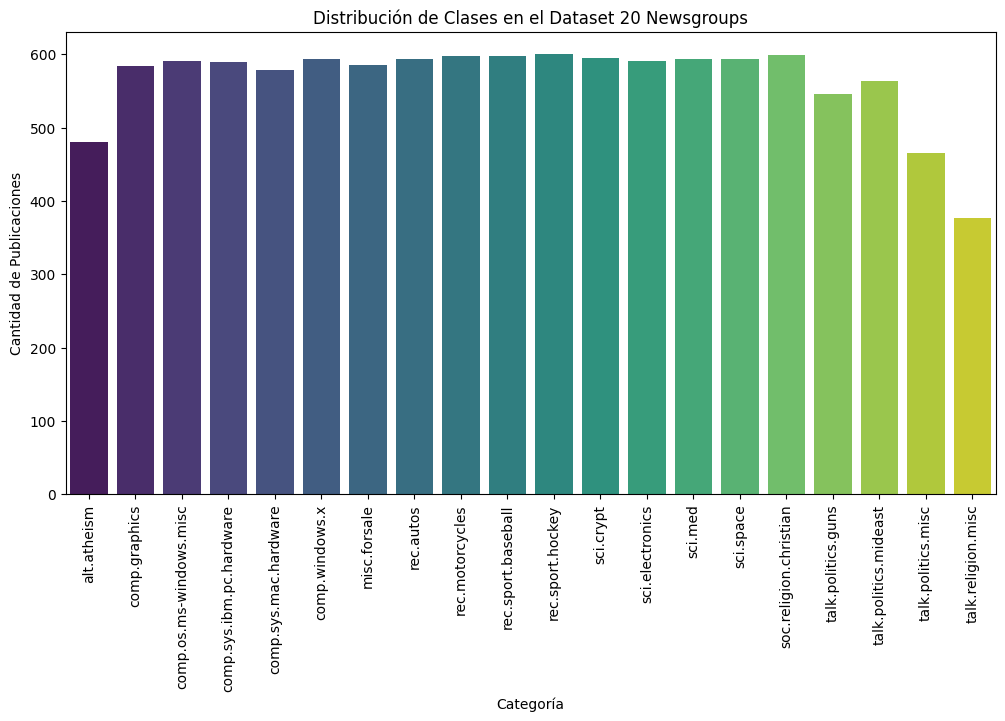

Categoría: alt.atheism
Ejemplo de texto:
dont sure look happened japanese citizens us world war ii youre prepared say lets round people stick concentration camp without trial short step gassing without trial seems nazis originally intended imprison jews final solution dreamt partly couldnt afford run camps devastation caused goerings total war werent gassed generally died malnutrition disease
--------------------------------------------------------------------------------
Categoría: comp.graphics
Ejemplo de texto:
weiteks addressphone number id like get information chip
--------------------------------------------------------------------------------
Categoría: comp.os.ms-windows.misc
Ejemplo de texto:
win downloaded several icons bmps cant figure change wallpaper use icons help would appreciated thanx brando
--------------------------------------------------------------------------------
Categoría: comp.sys.ibm.pc.hardware
Ejemplo de texto:
shows dont know much scsi scsi scsi controler

In [47]:
# Visualización de la distribución de clases
plt.figure(figsize=(12,6))
sns.countplot(x=df['target'], palette='viridis')
plt.xticks(ticks=range(len(dataset.target_names)), labels=dataset.target_names, rotation=90)
plt.xlabel("Categoría")
plt.ylabel("Cantidad de Publicaciones")
plt.title("Distribución de Clases en el Dataset 20 Newsgroups")
plt.show()

# Mostrar ejemplos de texto por categoría
for category in np.unique(df['target'])[:5]:
    print(f"Categoría: {dataset.target_names[category]}")
    print("Ejemplo de texto:")
    print(df[df['target'] == category]['text'].values[0][:500])
    print("-" * 80)

Vamos a almacenar las stopwords en inglés

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


C:\Users\User\AppData\Local\Temp\ipykernel_86272\3200499976.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['target'], palette='viridis')


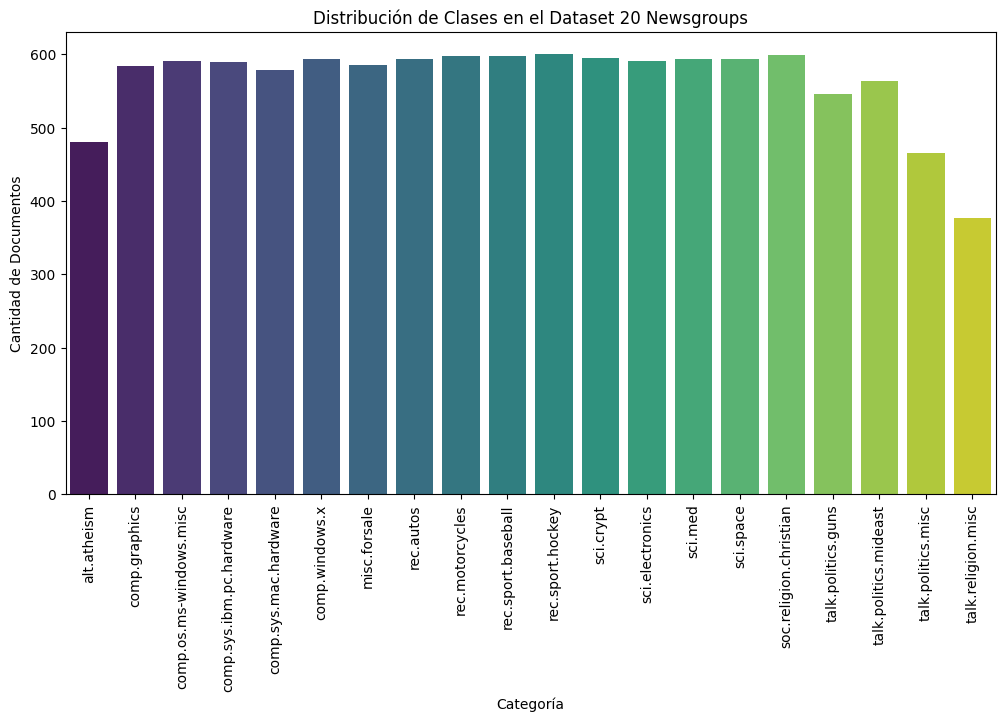

Accuracy: 0.6990720282810429
                          precision    recall  f1-score   support

             alt.atheism       0.89      0.32      0.47        97
           comp.graphics       0.69      0.69      0.69       104
 comp.os.ms-windows.misc       0.73      0.62      0.67       115
comp.sys.ibm.pc.hardware       0.57      0.76      0.65       123
   comp.sys.mac.hardware       0.92      0.60      0.73       126
          comp.windows.x       0.73      0.91      0.81       106
            misc.forsale       0.72      0.69      0.70       109
               rec.autos       0.85      0.71      0.78       139
         rec.motorcycles       0.80      0.74      0.77       122
      rec.sport.baseball       0.55      0.86      0.67       102
        rec.sport.hockey       0.85      0.84      0.85       108
               sci.crypt       0.65      0.94      0.76       125
         sci.electronics       0.83      0.66      0.74       114
                 sci.med       0.86      0.76 

In [ ]:
# Función de preprocesamiento de texto
def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres especiales y números
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Aplicar preprocesamiento
df['text'] = df['text'].apply(preprocess_text)

# Visualización de la distribución de clases
plt.figure(figsize=(12,6))
sns.countplot(x=df['target'], palette='viridis')
plt.xticks(ticks=range(len(dataset.target_names)), labels=dataset.target_names, rotation=90)
plt.xlabel("Categoría")
plt.ylabel("Cantidad de Documentos")
plt.title("Distribución de Clases en el Dataset 20 Newsgroups")
plt.show()

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Crear pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()) 
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Evaluar el modelo
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=dataset.target_names))

Finalmente, obtenemos una precicisión del 0.70%

Vamos a integrar MLflow para registrar métricas y comparar experimentos

In [48]:
acc = accuracy_score(y_test, y_pred)
mlflow.set_experiment('Despliegue Algoritmos BD14')
with mlflow.start_run(run_name='Práctica Despligue Algos BD14'):
    mlflow.log_metric("Precisión", acc)
    mlflow.log_param("Modelo Utilizado", "MultinomialNB")
    mlflow.log_param("Vectorizer", "TfidfVectorizer")

Hemos creado un Experimento nuevo en MLflow llamado: "Despliegue Algoritmos BD14"
Dentro hemos creado un nuevo run llamado: "Práctica Despligue Algos BD14"

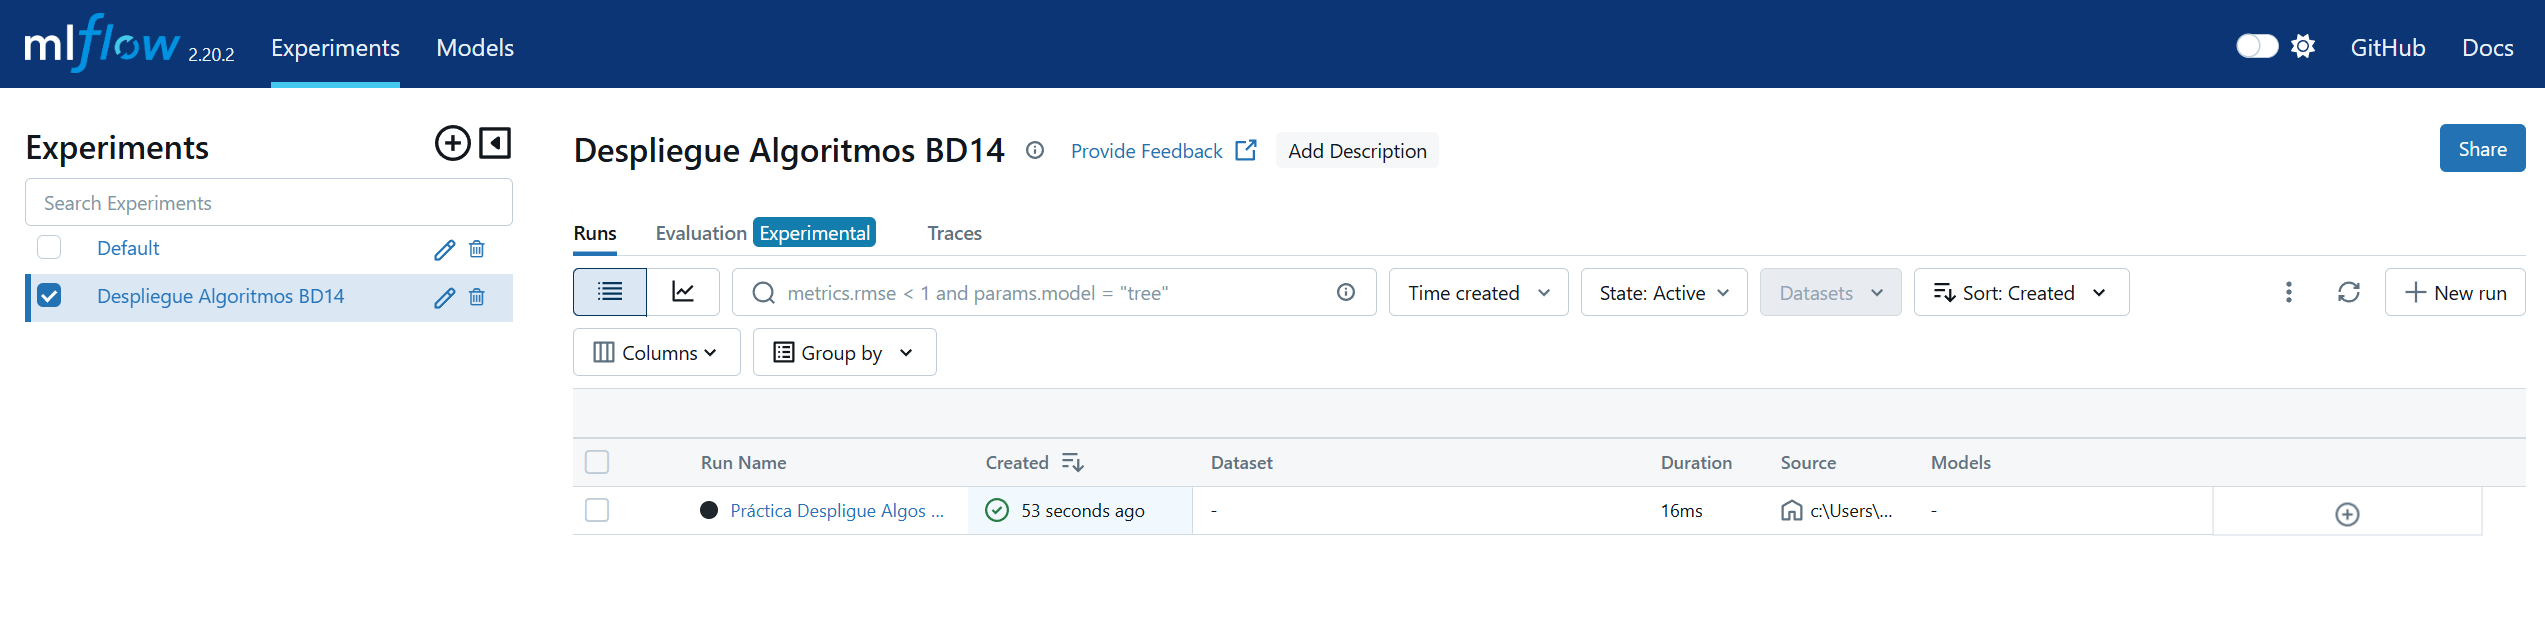

Dentro de este run hemos guardado los parámetros de:

-   Precisión (0.7)
-   Modelo Utilizado (MultinomialNB)
-   Vectorizer (TfidfVectorizer)

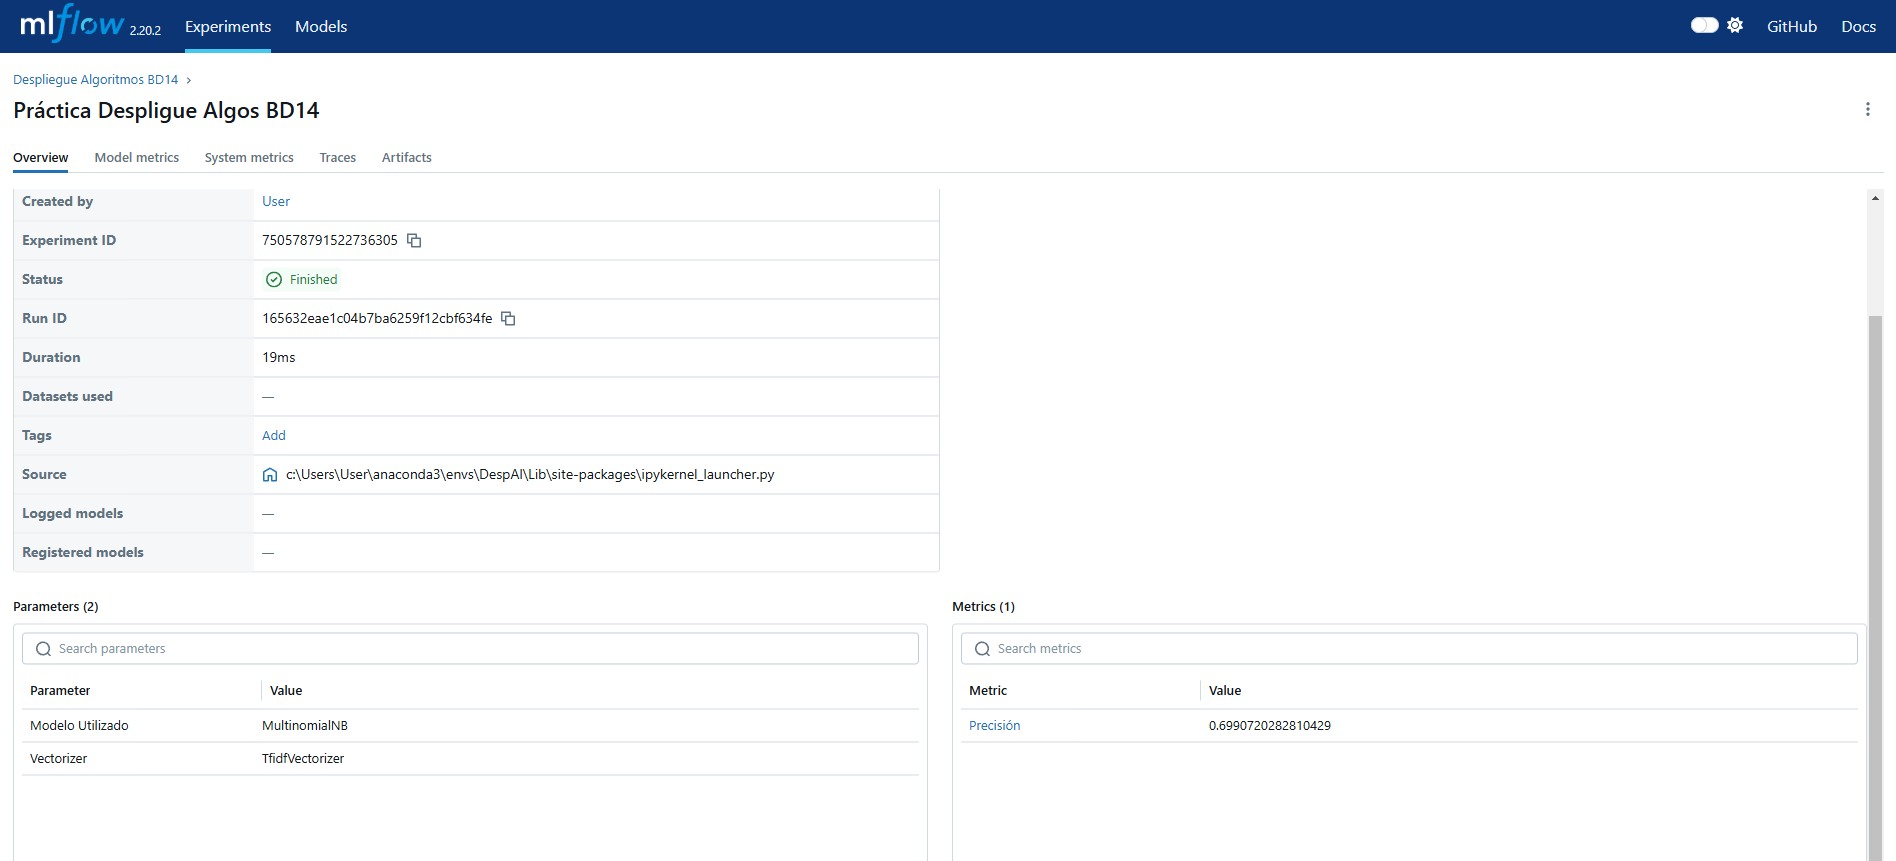

## Generar .py de funciones y main con al menos dos argumentos de entrada.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.sklearn

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def load_and_process_data():

    dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    df = pd.DataFrame({'text': dataset.data, 'target': dataset.target})
    df['text'] = df['text'].apply(preprocess_text)
    return df, dataset.target_names

def train_model(X_train, X_test, y_train, y_test):

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])
    
    mlflow.set_experiment("text_classification")
    with mlflow.start_run():
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
   
        mlflow.log_metric("accuracy", acc)
        mlflow.log_param("model", "MultinomialNB")
        mlflow.log_param("vectorizer", "TfidfVectorizer")
        mlflow.sklearn.log_model(pipeline, "text_classification_model")
        
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred))
    
    return pipeline



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vamos a utilizar como argumentos de entrada el tamaño para el conjunto de test y  la semilla para la función random

In [ ]:
#Tenemos que guardar el script de la celda anterior con el nombre de "funciones.py" para poder importar funciones como librería
import argparse
from funciones import load_and_process_data, train_model
from sklearn.model_selection import train_test_split

def main(test_size, random_state):
    df, target_names = load_and_process_data()
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=test_size, random_state=random_state)
    train_model(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Clasificación de texto con MLflow")
    parser.add_argument("--test_size", type=float, default=0.2, help="Tamaño del conjunto test")
    parser.add_argument("--random_state", type=int, default=42, help="Semilla para el random")
    args = parser.parse_args()
    main(args.test_size, args.random_state)

Vamos a probar este código cambiando las métricas desde la llamada del main

In [ ]:
python main.py --test_size 0.3 --random_state 123

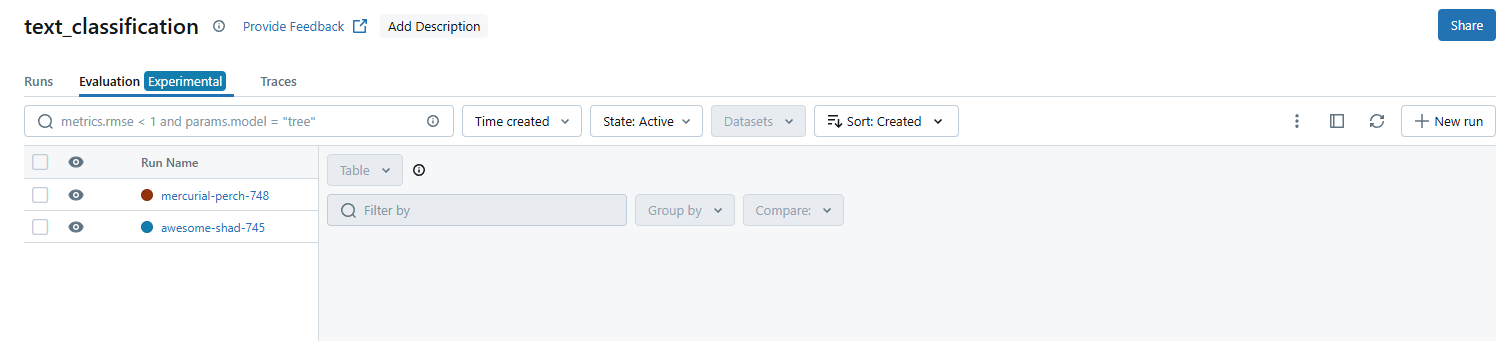

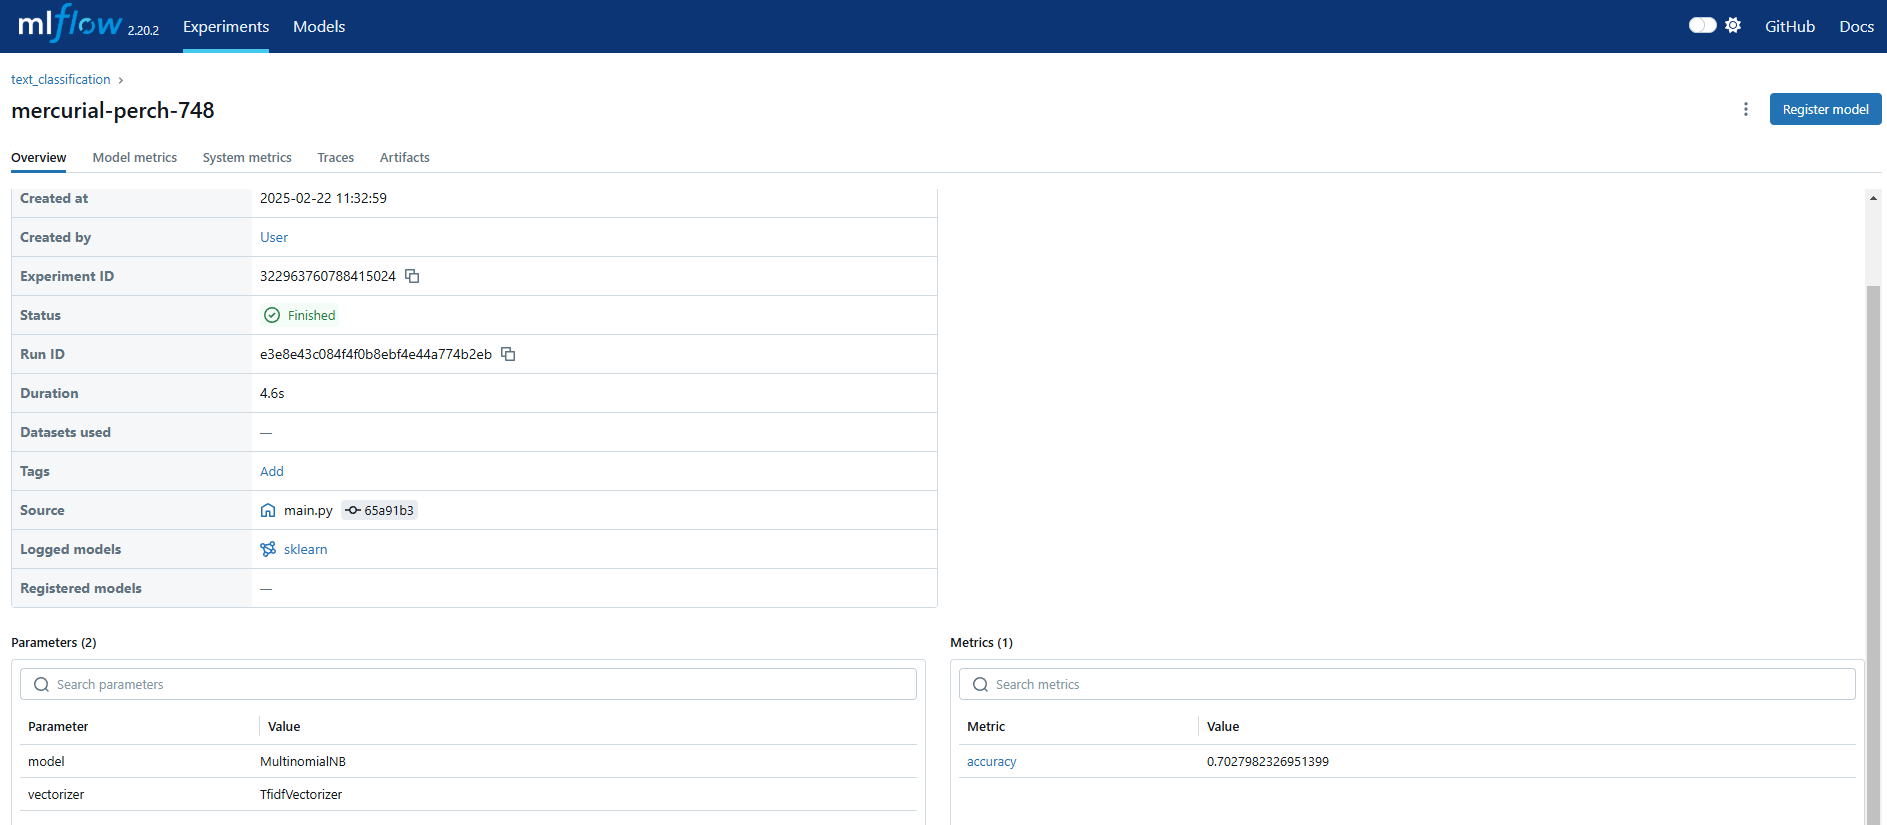

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

---

Este es el código utilizado para el ejercicio:

In [ ]:
from fastapi import FastAPI
from transformers import pipeline
from langdetect import detect

app = FastAPI()

# Módulo 1: Este es un módulo básico para dar la bienvenida
@app.get("/")
def home():
    return {"message": "Bienvenido a la API de la práctica final de Despliegue de Algoritmos"}

# Módulo 2: En este módulo pedimos un nombre y saludamos
@app.get("/saludo/")
def saludo(nombre: str = "Pablo"):
    return {"mensaje": f"Hola, {nombre}. ¡Bienvenido a la API de la práctica!"}

# Módulo 3: En este módulo pedimos un texto y analizamos el sentimiento
sentiment_pipeline = pipeline("sentiment-analysis")

@app.get("/sentiment/")
def analizar_sentimiento(texto: str):
    resultado = sentiment_pipeline(texto)
    return {"texto": texto, "sentimiento": resultado[0]}

# Módulo 4: En este módulo hacemos un resumen de un texto
summarization_pipeline = pipeline("summarization")

@app.get("/resumir/")
def resumir_texto(texto: str):
    resultado = summarization_pipeline(texto, max_length=50, min_length=10, do_sample=False)
    return {"original": texto, "resumen": resultado[0]['summary_text']}


# Módulo 5: En este módulo hacemos la traducción de un texto
@app.get("/traducir/")
def traducir(texto: str, idioma_destino: str = "en"):
    try:
        # Detectar automáticamente el idioma del texto de entrada
        idioma_origen = detect(texto)

        # Construir el nombre del modelo de Hugging Face
        modelo_traduccion = f"Helsinki-NLP/opus-mt-{idioma_origen}-{idioma_destino}"

        # Cargar el modelo de traducción
        translator = pipeline("translation", model=modelo_traduccion)

        # Traducir el texto
        resultado = translator(texto, max_length=512)
        return {
            "texto_original": texto,
            "idioma_origen_detectado": idioma_origen,
            "idioma_destino": idioma_destino,
            "traduccion": resultado[0]['translation_text']
        }

    except Exception as e:
        return {"error": f"No se pudo traducir. Verifica los idiomas soportados. {str(e)}"}



Módulo 1:

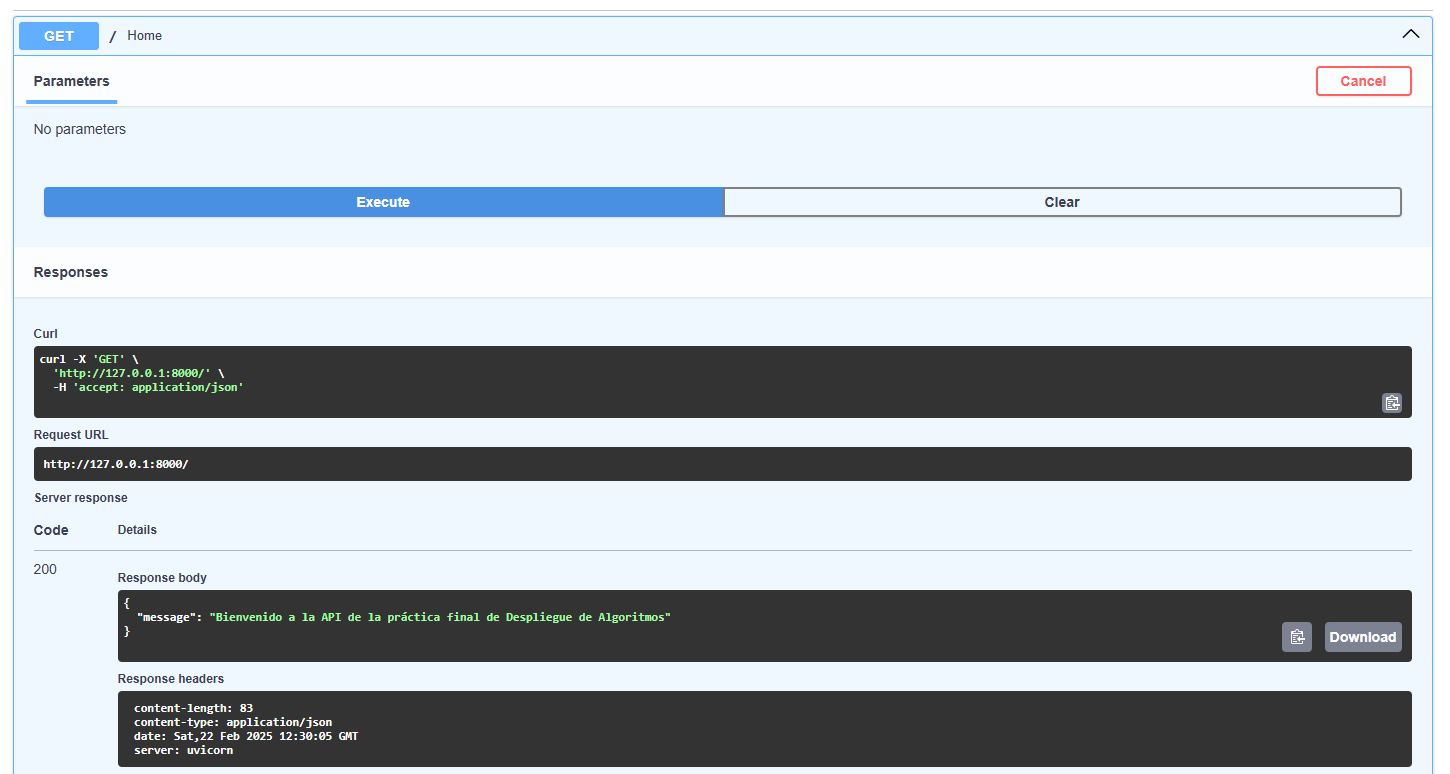

Módulo 2:

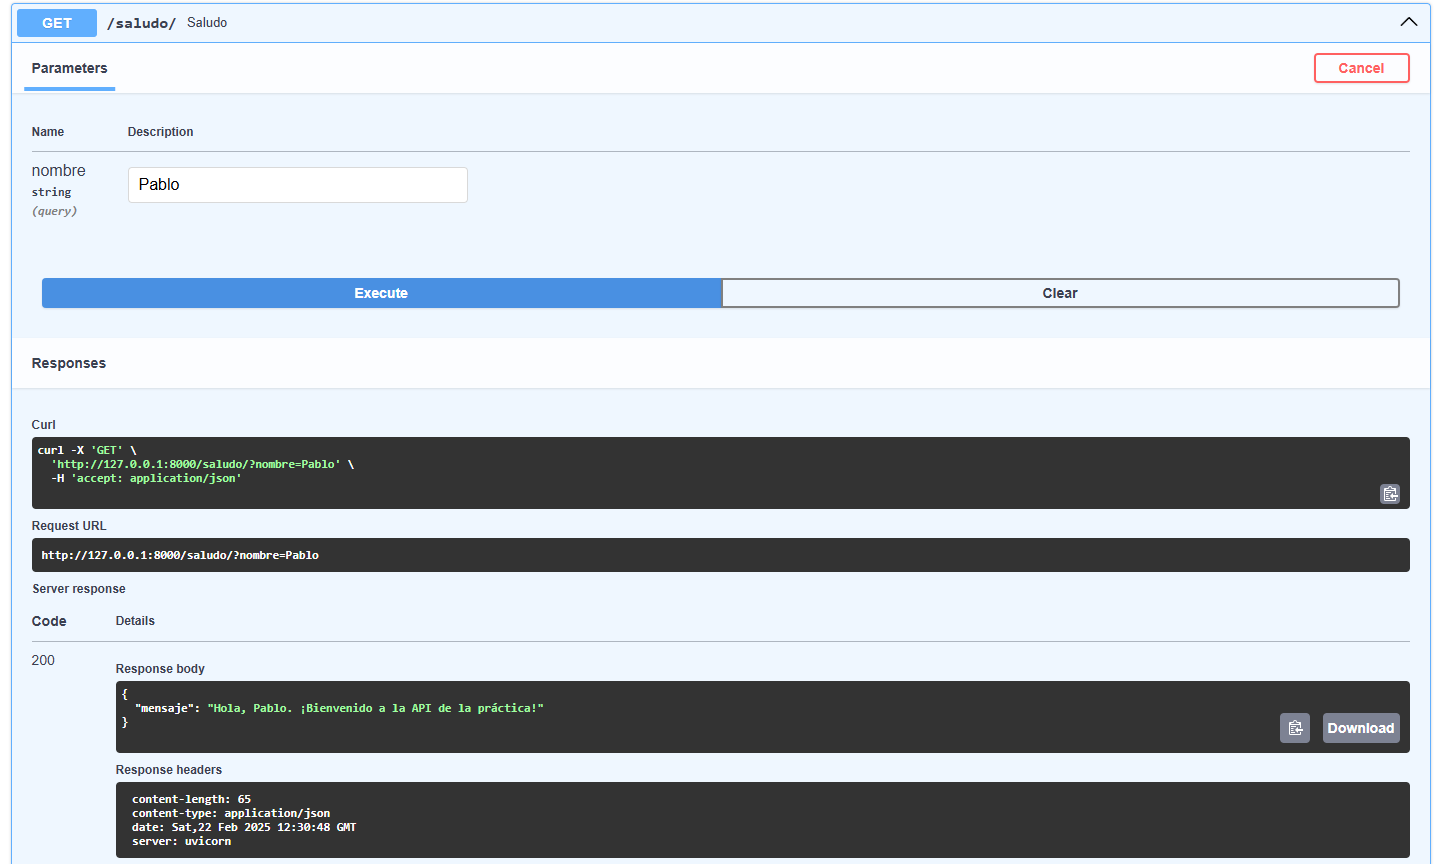

Módulo 3:

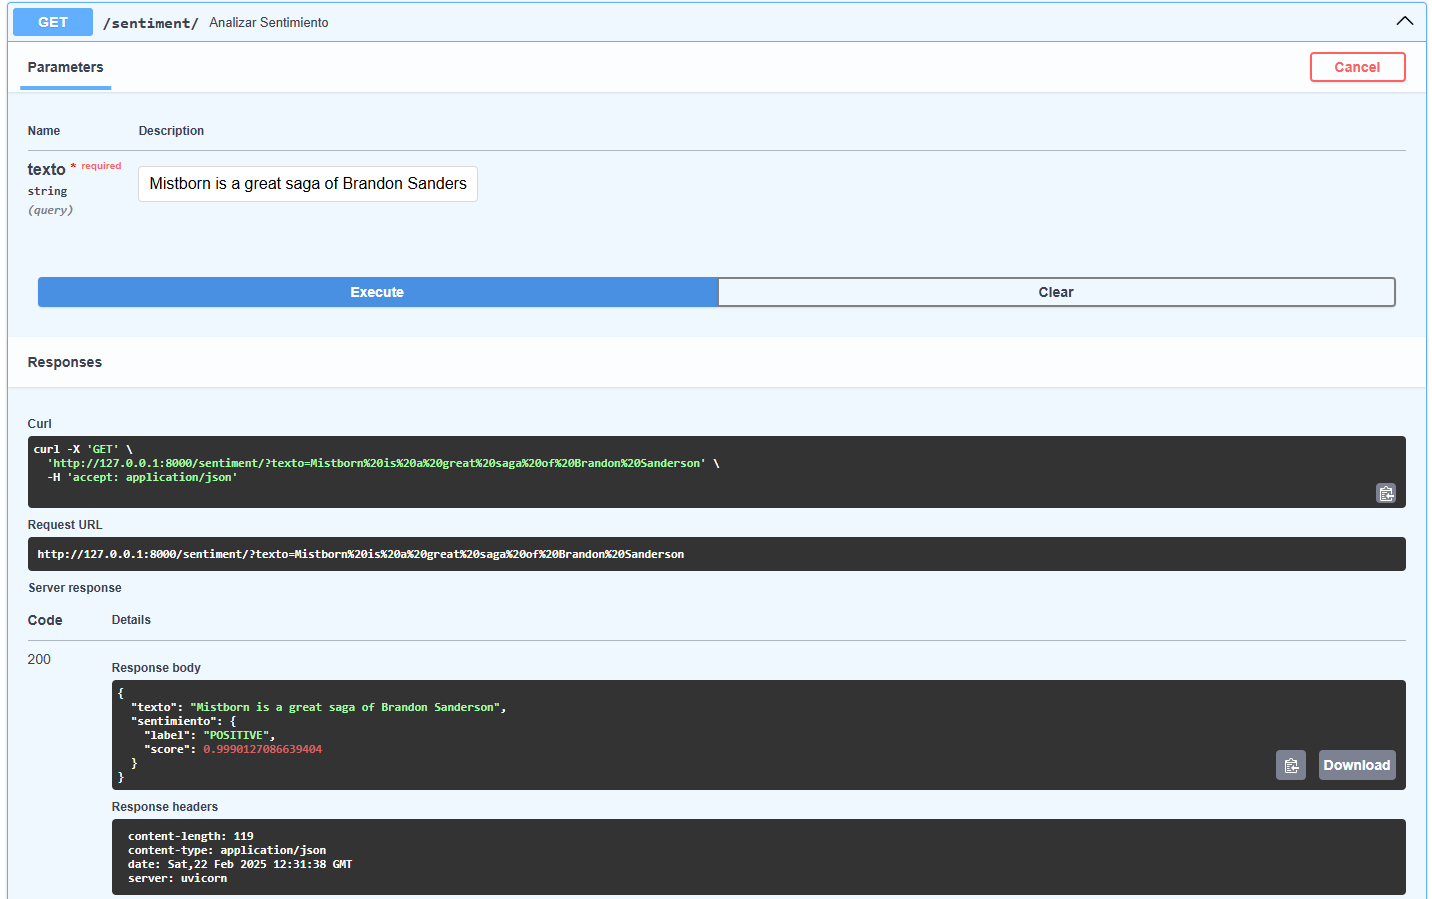

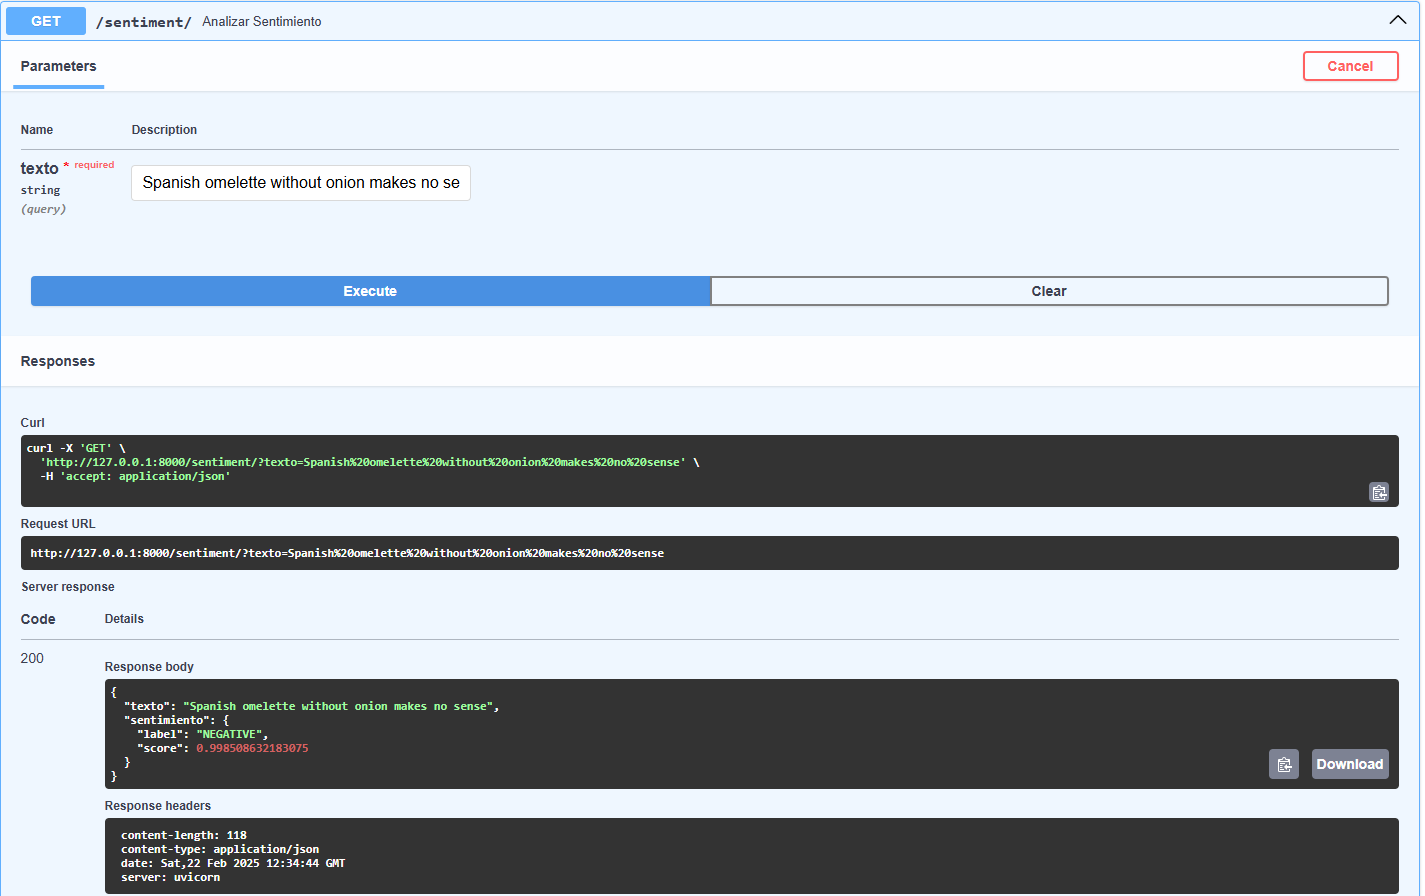

Módulo 4:

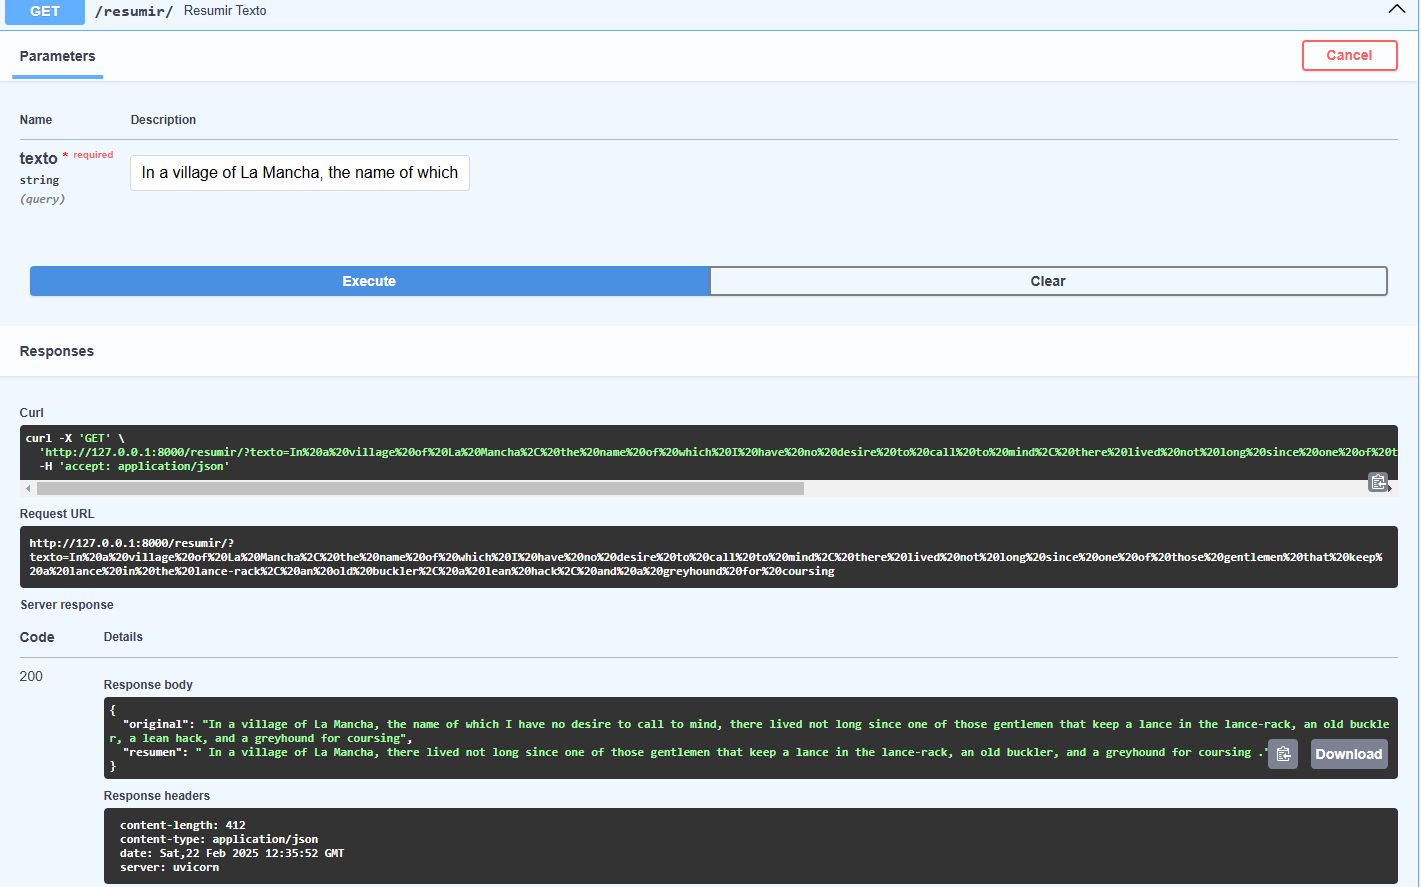

Módulo 5:

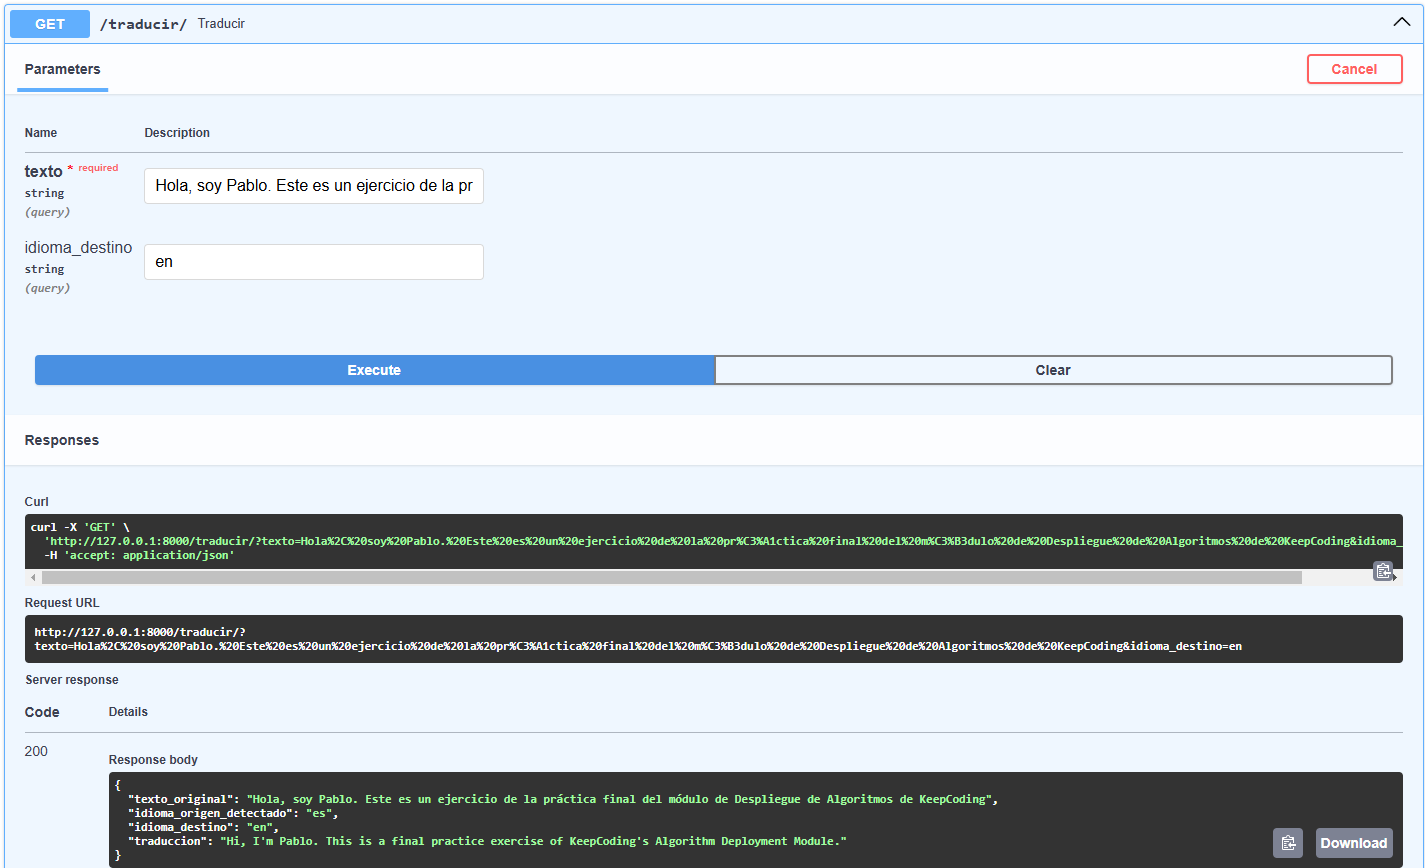

He intentado hacer la parte opcional, pero no consigo hacer que funcione el Docker en Google Cloud 🥹​